In [1]:
import numpy as np
import rosatX as rx
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

In [2]:
rosat = rx.ROSATResponse('pspcc_gain1_256.rsp')

/tmp/ipykernel_139331/1349700096.py:4: RuntimeWarning: invalid value encountered in divide
  spec = rosat.get_spectrum_in(kT, 0.)/np.diff(rosat.get_energ_in_bins())
/tmp/ipykernel_139331/1349700096.py:5: RuntimeWarning: invalid value encountered in divide
  spec_con = rosat.get_spectrum_in(kT, 0., dolines=False, dopseudo=False)/np.diff(rosat.get_energ_in_bins())


Text(0.5, 0, "$\\varepsilon'\\,\\,[{\\rm keV}]$")

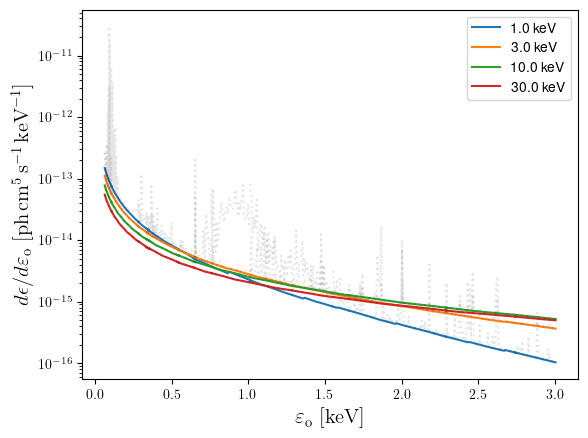

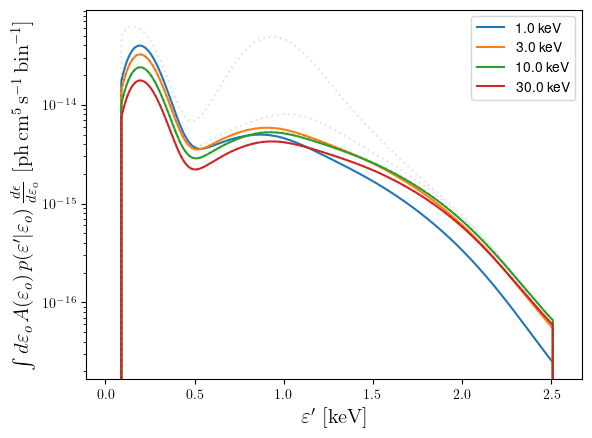

In [3]:
plt.figure()
emean = rosat.get_energ_in_mean()
for kT in [1.0, 3.0, 10.0, 30.0]:
    spec = rosat.get_spectrum_in(kT, 0.)/np.diff(rosat.get_energ_in_bins())
    spec_con = rosat.get_spectrum_in(kT, 0., dolines=False, dopseudo=False)/np.diff(rosat.get_energ_in_bins())
    plt.plot(emean, spec_con, '-', label=f'{kT} keV')
    plt.plot(emean, spec, 'k:', alpha=0.1)
plt.yscale('log')
plt.legend()
plt.ylabel(r'$d\epsilon/d\varepsilon_{\rm o}\,\,[{\rm ph}\,{\rm cm}^5\,{\rm s}^{-1}\,{\rm keV}^{-1}]$',
           fontsize=15)
plt.xlabel(r'$\varepsilon_{\rm o}\,\,[{\rm keV}]$', fontsize=15)

plt.figure()
emean = rosat.get_energ_out_mean()
for kT in [1.0, 3.0, 10.0, 30.0]:
    spec = rosat.get_convolved_spectrum_out(kT, 0.)
    spec_con = rosat.get_convolved_spectrum_out(kT, 0., dolines=False, dopseudo=False)
    plt.plot(emean, spec_con, '-', label=f'{kT} keV')
    plt.plot(emean, spec, 'k:', alpha=0.1)
plt.yscale('log')
plt.legend()
plt.ylabel(r"$\int d\varepsilon_o\,A(\varepsilon_o)\,p(\varepsilon'|\varepsilon_o)\,\frac{d\epsilon}{d\varepsilon_{\rm o}}\,\,[{\rm ph}\,{\rm cm}^5\,{\rm s}^{-1}\,{\rm bin}^{-1}]$",
           fontsize=15)
plt.xlabel(r"$\varepsilon'\,\,[{\rm keV}]$", fontsize=15)

Text(0.5, 0, '$T\\,\\,[{\\rm K}]$')

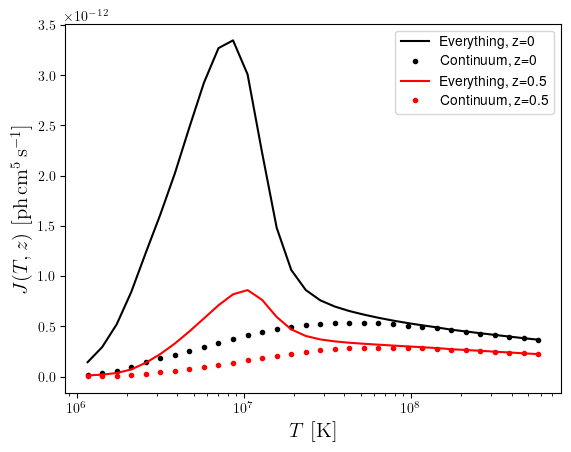

In [4]:
plt.figure()
kTs = np.geomspace(0.1, 50.0, 32)
# Transforms keV to Kelvin
kT2T = 11604518.1
z = 0.
Js_cont = np.array([rosat.get_integrated_spectrum(kT, z, 0.5, 2.0,
                                                  dolines=False, dopseudo=False)
                    for kT in kTs])
Js_all = np.array([rosat.get_integrated_spectrum(kT, z, 0.5, 2.0)
                   for kT in kTs])
plt.plot(kTs*kT2T, Js_all, 'k-', label='Everything, z=0')
plt.plot(kTs*kT2T, Js_cont, 'k.', label='Continuum, z=0')
z = 0.5
Js_cont = np.array([rosat.get_integrated_spectrum(kT, z, 0.5, 2.0,
                                                  dolines=False, dopseudo=False)
                    for kT in kTs])
Js_all = np.array([rosat.get_integrated_spectrum(kT, z, 0.5, 2.0)
                   for kT in kTs])
plt.plot(kTs*kT2T, Js_all, 'r-', label='Everything, z=0.5')
plt.plot(kTs*kT2T, Js_cont, 'r.', label='Continuum, z=0.5')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.ylabel(r"$J(T,z)\,\,[{\rm ph}\,{\rm cm}^5\,{\rm s}^{-1}]$", fontsize=15)
plt.xlabel(r"$T\,\,[{\rm K}]$", fontsize=15)

Faster with pre-interpolation

In [5]:
kTmin = 0.1
kTmax = 50.0
nkT = 32
zmax = 1.0
nz = 4
emin = 0.5
emax = 2.0
ip_cont = rosat.get_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax,
                                               dolines=False, dopseudo=False)
ip_all = rosat.get_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax)

Text(0.5, 0, '$T\\,\\,[{\\rm K}]$')

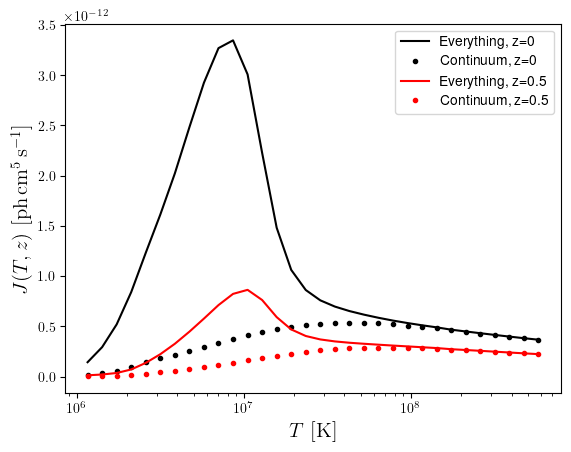

In [6]:
plt.figure()
kTs = np.geomspace(0.1, 50.0, 32)
# Transforms keV to Kelvin
kT2T = 11604518.1
z = 0.
ev = np.array([[lkt, z] for lkt in np.log(kTs)])
Js_cont_b = np.exp(ip_cont(ev))
Js_all_b = np.exp(ip_all(ev))
plt.plot(kTs*kT2T, Js_all_b, 'k-', label='Everything, z=0')
plt.plot(kTs*kT2T, Js_cont_b, 'k.', label='Continuum, z=0')
z = 0.5
ev = np.array([[lkt, z] for lkt in np.log(kTs)])
Js_cont_b = np.exp(ip_cont(ev))
Js_all_b = np.exp(ip_all(ev))
plt.plot(kTs*kT2T, Js_all_b, 'r-', label='Everything, z=0.5')
plt.plot(kTs*kT2T, Js_cont_b, 'r.', label='Continuum, z=0.5')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.ylabel(r"$J(T,z)\,\,[{\rm ph}\,{\rm cm}^5\,{\rm s}^{-1}]$", fontsize=15)
plt.xlabel(r"$T\,\,[{\rm K}]$", fontsize=15)